In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import vizuread as pat
import logging

logging.basicConfig(format='[%(levelname)s] [%(asctime)s] [%(module)s] %(message)s', datefmt='%H:%M:%S')


def get_reads_stats(reads, receiver) :
    evidence_reads = 0  # reads mapping for a given transloc
    noise_reads = 0     # reads mapping for other transloc
    proper_reads = 0    # properly paired reads, not bearing any translocation

    for read in reads :
        if read.is_properly_paired : 
            proper_reads += 1
        elif read.receiver_chr == receiver :
            evidence_reads += 1
        else :
            noise_reads += 1

    return evidence_reads, noise_reads, proper_reads

def check_4_14_risk(c1, end1, end2) :
    """
    Check si une translocation 4-14 est à haut risque ou pas 

    cf `Location of the t(4;14) translocation breakpoint within the NSD2 gene identifies a subset of high-risk NDMM patients`

    Définition des régions : https://genome-euro.ucsc.edu/cgi-bin/hgGene?hgg_gene=ENST00000508803.6&hgg_chrom=chr4&hgg_start=1871392&hgg_end=1982192&hgg_type=knownGene&db=hg38

    ```verb
    Transcript (Including UTRs)
    Position: hg38 chr4:1,871,393-1,982,192 Size: 110,800 Total Exon Count: 22 Strand: +
    Coding Region
    Position: hg38 chr4:1,900,655-1,978,909 Size: 78,255 Coding Exon Count: 21  
    """
    # On ne regarde que la position de fin du breakpoint 
    end = end1 if c1 == "chr4" else end2
    if int(end) < 1871393 :
        return "Low risk"
    elif int(end) < 1900655 :
        return "Medium risk"
    else : 
        return "High risk"

def plot_transloc(bam:Path, region:str, patient:str, transloc_id:str, transloc_type:str, balance_type:str, min_reads_covering, min_reads_total) :

    c1, c2 = region.split()
    # this way, chr14 is always c2
    if "chr14" in c1 :
        c1, c2 = c2, c1

    reads1 = list(pat.get_reads_from(
        bam, c1,
        samtools_command="samtools",
    ))

    reads2 = list(pat.get_reads_from(
        bam, c2,
        samtools_command="samtools",
    ))

    evidence_reads, noise_reads, proper_reads = get_reads_stats(reads1, c2.split(":")[0])
    total_reads = evidence_reads + noise_reads + proper_reads

    reads1 = [r for r in reads1 if not r.is_properly_paired]
    reads2 = [r for r in reads2 if not r.is_properly_paired]

    get_m_size = lambda x, func: str(func(r.ref_span for r in x)) if x else "None"
    minmax_read1 = "-->".join([get_m_size(reads1, min), get_m_size(reads1, max)])
    minmax_read2 = "-->".join([get_m_size(reads2, min), get_m_size(reads2, max)])

    fig, ax = plt.subplots(1,2, figsize=(12,5))
    pat.plot_region(reads=reads1, ax=ax[0])
    ax[0].set_title(f"{c1} (min/max={minmax_read1})")

    pat.plot_region(reads=reads2, ax=ax[1], piling="compact")
    ax[1].set_title(f"{c2} (min/max={minmax_read2})")

    if c1 == "chr4" or c2 == "chr4" :
        risk = "(" + check_4_14_risk(c1, int(c1.split("-")[-1]), int(c2.split("-")[-1])) + ")"
    else :
        risk = ""

    plt.suptitle(
        r"$\bf{" + patient+ "}$" + f" : {transloc_id} {risk}\n"
        f"{transloc_type.lower()}, {balance_type.lower()}\n"
        f"Reads porteurs / Reads totaux : {evidence_reads}/{total_reads}\n"
        f"Bruit: {noise_reads}"
    )
    plt.tight_layout()

    return (
        fig,    # return the figure to give plotting responsibility elsewhere 
        (total_reads >= min_reads_total and evidence_reads >= min_reads_covering
        ),      # return if the given transloc is passing filters (but we plot in all cases, just in a different place)
        total_reads
    )


[WARNING] [15:55:12] [vizuread] Read starting with a clip, shifted by -15 : chr8:127104694 15S55M forward=False
[WARNING] [15:55:12] [vizuread] Read starting with a clip, shifted by -15 : chr8:127104694 15S55M forward=False
[WARNING] [15:55:12] [vizuread] Read starting with a clip, shifted by -33 : chr8:127104694 33S38M forward=False
[WARNING] [15:55:12] [vizuread] Read starting with a clip, shifted by -33 : chr8:127104694 33S38M forward=False
[WARNING] [15:55:12] [vizuread] Read starting with a clip, shifted by -15 : chr8:127104694 15S55M forward=False
[WARNING] [15:55:12] [vizuread] Read starting with a clip, shifted by -15 : chr8:127104694 15S55M forward=False
[WARNING] [15:55:12] [vizuread] Read starting with a clip, shifted by -10 : chr8:127104694 10S61M forward=False
[WARNING] [15:55:12] [vizuread] Read starting with a clip, shifted by -10 : chr8:127104694 10S61M forward=False
[WARNING] [15:55:12] [vizuread] Read starting with a clip, shifted by -6 : chr8:127104694 6S64M forward=

samtools view  /run/user/1002/kio-fuse-yRlyTy/sftp/pavageau@hpclogin:22/labos/UGM/routine/240702_NS500523_1110_AHJJTLBGXW_test_new_panel_v4.1/bam/T38689.bam chr8:127104695-127104856
samtools view  /run/user/1002/kio-fuse-yRlyTy/sftp/pavageau@hpclogin:22/labos/UGM/routine/240702_NS500523_1110_AHJJTLBGXW_test_new_panel_v4.1/bam/T38689.bam chr14:105742988-105743319


[WARNING] [15:55:12] [vizuread] Read starting with a clip, shifted by -9 : chr14:105743041 9S61M forward=False
[WARNING] [15:55:12] [vizuread] Read starting with a clip, shifted by -9 : chr14:105743041 9S61M forward=False
[WARNING] [15:55:12] [vizuread] Read starting with a clip, shifted by -5 : chr14:105743202 5S61M4S forward=False
[WARNING] [15:55:12] [vizuread] Read starting with a clip, shifted by -5 : chr14:105743202 5S61M4S forward=False
[WARNING] [15:55:12] [vizuread] Read starting with a clip, shifted by -4 : chr14:105743202 4S61M5S forward=False
[WARNING] [15:55:12] [vizuread] Read starting with a clip, shifted by -4 : chr14:105743202 4S61M5S forward=False
[WARNING] [15:55:12] [vizuread] Read starting with a clip, shifted by -5 : chr14:105743202 5S61M4S forward=False
[WARNING] [15:55:12] [vizuread] Read starting with a clip, shifted by -5 : chr14:105743202 5S61M4S forward=False
[WARNING] [15:55:12] [vizuread] Read starting with a clip, shifted by -5 : chr14:105743202 5S61M5S f

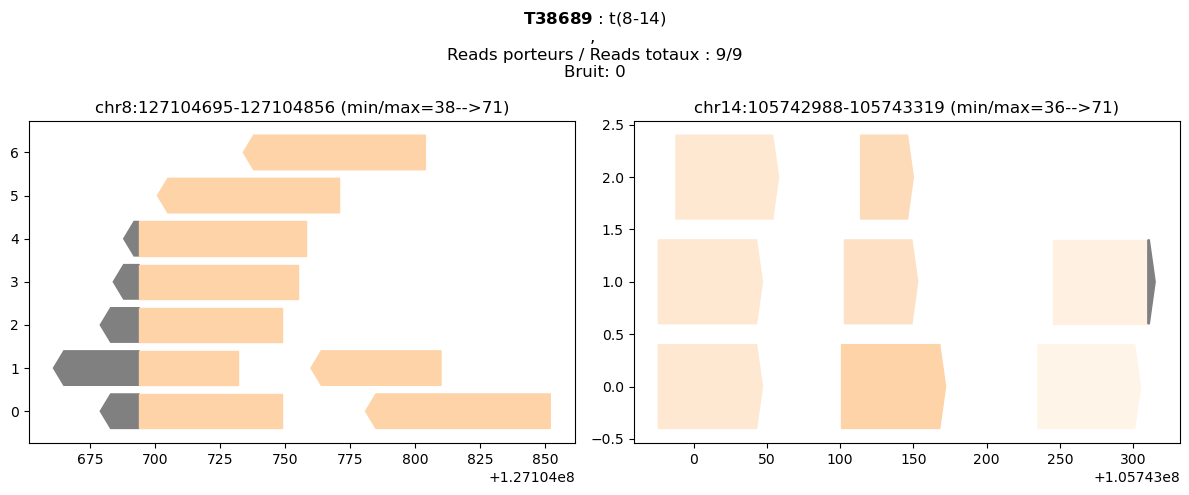

In [4]:
_  = plot_transloc(
    "/run/user/1002/kio-fuse-yRlyTy/sftp/pavageau@hpclogin:22/labos/UGM/routine/240702_NS500523_1110_AHJJTLBGXW_test_new_panel_v4.1/bam/T38689.bam",
    "chr8:127104695-127104856 chr14:105742988-105743319",
    "T38689", "t(8-14)", "", "", 5, 10
)